In [11]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1."
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "true"
# import jax
# jax.config.update('jax_platform_name', 'cpu')
# jax.devices()

In [12]:
import jax
import optax

import demes, demesdraw, sparse
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from momi3.Params import Params
from momi3.MOMI import Momi
from momi3.optimizers import optax_for_momi
from momi3.utils import bootstrap_sample

import re
import math
import pickle
import tskit

from tqdm.notebook import tqdm, trange

from scipy import stats, optimize
import numpy as np
import jax.numpy as jnp

from ast import literal_eval

from train import get_demo, get_params

In [13]:
jsfs = np.load('jsfs_UNIF_Yoruba_French_Papuan_Vindija_Denisovan_3419145_108.npy')

In [14]:
sampled_demes = ('Yoruba', 'French', 'Papuan', 'Vindija', 'Denisovan')
sample_sizes = [i - 1 for i in jsfs.shape]

In [15]:
print('sample sizes')
for i, j in zip(sampled_demes, sample_sizes):
    print(f"{i}: {j}")

sample sizes
Yoruba: 214
French: 56
Papuan: 30
Vindija: 2
Denisovan: 2


In [16]:
print(f'# Number of SNPs: {jsfs.sum()/1e6:.1f} Millions')

# Number of SNPs: 29.9 Millions


In [17]:
print(f'# Non-zero SFS entries: {(jsfs != 0).sum()}')

# Non-zero SFS entries: 453047


In [18]:
demo = get_demo('pulse')

In [37]:
min(ret['history']['LLs'])

51214224.0

In [34]:
min(ret['history']['LLs'])

51214164.0

In [33]:
ind = np.argmin(ret['history']['LLs'])
ttd = ret['history']['ttds'][ind]

In [25]:
momi = Momi(demo, sampled_demes, sample_sizes, jitted=True)

In [26]:
params = Params(momi)
params.set_train_all_etas(True)
params.set_train_all_pis(True)
params.set_train('eta_0', False) # Ancestral pop size is not inferred
print(f"ancestral size: {params['eta_0']}")

ancestral size: 7310.0


In [27]:
params.set_optimization_results(ttd)

In [28]:
params.set_train('eta_12', False)
params.set_train('eta_10', False)

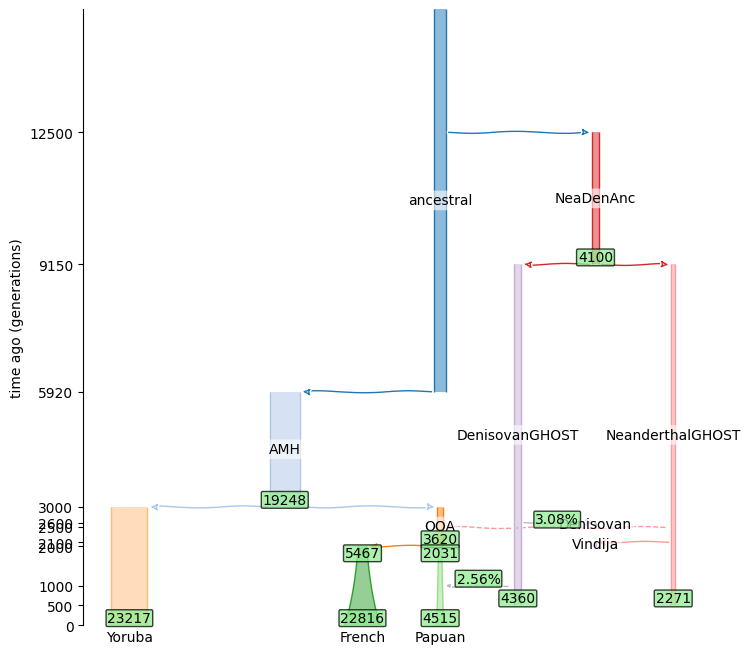

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
params.tubes(True, False, log_time=False, hide_non_inferreds=True, fontsize=10, ax=ax)
plt.savefig('spgpu05.pdf', format='pdf')

In [16]:
inferred_demo = params.demo_graph

In [19]:
demes.dump(inferred_demo, filename='arc5_pulse_inferred.yaml', format='yaml', simplified=False)

# Sampled model

In [48]:
demo = get_demo('pulse')

In [49]:
#jsfs = bootstrap_sample(jsfs, int(1e6))

In [50]:


sampled_n_dict = dict(zip(sampled_demes, sample_sizes))

## Infer pop sizes

In [51]:
nnz = (jsfs != 0).sum() + 3
nnz

453050

In [52]:
nnz / 7

64721.42857142857

In [53]:
momi = Momi(demo, sampled_demes, sample_sizes, jitted=True, batch_size=65000, low_memory=True)

In [54]:
params = Params(momi)

In [55]:
bounds = momi.bound_sampler(params, 1000, min_lineages=2)
momi = momi.bound(bounds)

In [56]:
params.set_train_all_etas(True)
params.set_train_all_pis(True)
params.set_train('eta_0', False) # We will not infer the size of ancestral pop
print(f"ancestral size: {params['eta_0']}")

ancestral size: 7310.0


In [71]:
def get_lr_vector(theta_train_dict, lr, transformed=True):
    train_keys = tuple(theta_train_dict)
    lr_vec = []
    for i in train_keys:
        if i.find('eta') != -1:
            lr_vec.append(lr * 100)
        elif i.find('pi') != -1:
            lr_vec.append(lr)

    return jnp.array(lr_vec)

In [79]:
lr = 0.05

In [85]:
lr_vec

Array([5.  , 5.  , 5.  , 5.  , 5.  , 5.  , 5.  , 5.  , 5.  , 5.  , 5.  ,
       5.  , 0.05, 0.05], dtype=float32)

In [80]:
transformed = True

theta_train_dict = params.theta_train_dict(transformed)
lr_vec = get_lr_vector(theta_train_dict, lr)
optimizer = optax.adabelief(learning_rate=lr_vec)

theta_train = jnp.array(list(theta_train_dict.values()))
opt_state = optimizer.init(theta_train)
history = dict(LLs=[], ttds=[])

In [81]:
dict(zip(tuple(theta_train_dict), theta_train))

{'softplus(eta_1)': Array(19053.785, dtype=float32),
 'softplus(eta_2)': Array(4317.0215, dtype=float32),
 'softplus(eta_3)': Array(20673.04, dtype=float32),
 'softplus(eta_4)': Array(4440.437, dtype=float32),
 'softplus(eta_5)': Array(22714.848, dtype=float32),
 'softplus(eta_6)': Array(2394.9377, dtype=float32),
 'softplus(eta_7)': Array(4582.5347, dtype=float32),
 'softplus(eta_8)': Array(5014.166, dtype=float32),
 'softplus(eta_9)': Array(5803.2114, dtype=float32),
 'softplus(eta_10)': Array(29.49204, dtype=float32),
 'softplus(eta_11)': Array(6040.512, dtype=float32),
 'softplus(eta_12)': Array(26.488695, dtype=float32),
 'logit(pi_0)': Array(-2.944439, dtype=float32),
 'logit(pi_1)': Array(-3.6635616, dtype=float32)}

In [82]:
theta_train_dict, opt_state, history = optax_for_momi(
    optimizer,
    momi,
    params,
    jsfs,
    niter=5,
    transformed=transformed,
    theta_train_dict=theta_train_dict,
    opt_state=opt_state,
    history=history
)

  0%|          | 0/5 [00:00<?, ?it/s]

In [83]:
theta_train_dict

{'softplus(eta_1)': Array(19026.193, dtype=float32),
 'softplus(eta_2)': Array(4289.644, dtype=float32),
 'softplus(eta_3)': Array(20700.596, dtype=float32),
 'softplus(eta_4)': Array(4468.1123, dtype=float32),
 'softplus(eta_5)': Array(22738.895, dtype=float32),
 'softplus(eta_6)': Array(2368.0388, dtype=float32),
 'softplus(eta_7)': Array(4555.9404, dtype=float32),
 'softplus(eta_8)': Array(4986.6064, dtype=float32),
 'softplus(eta_9)': Array(5777.4453, dtype=float32),
 'softplus(eta_10)': Array(34.085243, dtype=float32),
 'softplus(eta_11)': Array(6019.2573, dtype=float32),
 'softplus(eta_12)': Array(25.101843, dtype=float32),
 'logit(pi_0)': Array(-3.212416, dtype=float32),
 'logit(pi_1)': Array(-3.9200664, dtype=float32)}

In [76]:
%%time
v, g = momi.loglik_with_gradient(params, jsfs, transformed=True)

CPU times: user 15.4 s, sys: 755 ms, total: 16.2 s
Wall time: 16.1 s


In [ ]:
# Training
theta_train_dict, opt_state, history = optax_for_momi(
    optimizer, momi, params, jsfs, niter=100, transformed=True, 
    theta_train_dict=theta_train_dict,
    opt_state=opt_state, history=history)

  0%|          | 0/100 [00:00<?, ?it/s]

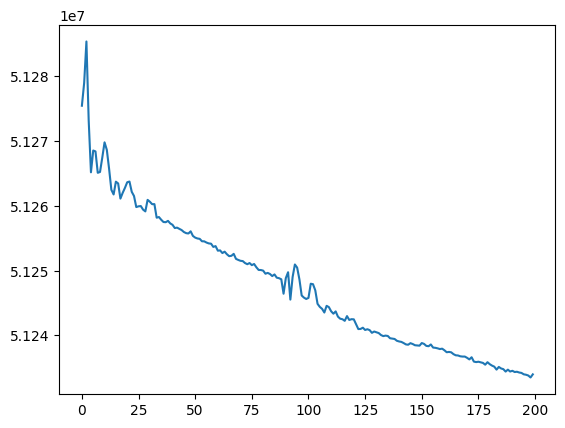

In [87]:
plt.plot(history['LLs'])

In [88]:
theta_train_dict

{'logit(pi_0)': Array(-3.4554625, dtype=float32),
 'logit(pi_1)': Array(-3.7009048, dtype=float32),
 'softplus(eta_1)': Array(18988.25, dtype=float32),
 'softplus(eta_10)': Array(31.495607, dtype=float32),
 'softplus(eta_11)': Array(5540.601, dtype=float32),
 'softplus(eta_12)': Array(27.59023, dtype=float32),
 'softplus(eta_2)': Array(3830.0425, dtype=float32),
 'softplus(eta_3)': Array(21408.549, dtype=float32),
 'softplus(eta_4)': Array(5044.6113, dtype=float32),
 'softplus(eta_5)': Array(22907.314, dtype=float32),
 'softplus(eta_6)': Array(2113.4006, dtype=float32),
 'softplus(eta_7)': Array(4382.2676, dtype=float32),
 'softplus(eta_8)': Array(4340.695, dtype=float32),
 'softplus(eta_9)': Array(4958.754, dtype=float32)}

In [89]:
params.set_optimization_results(theta_train_dict)

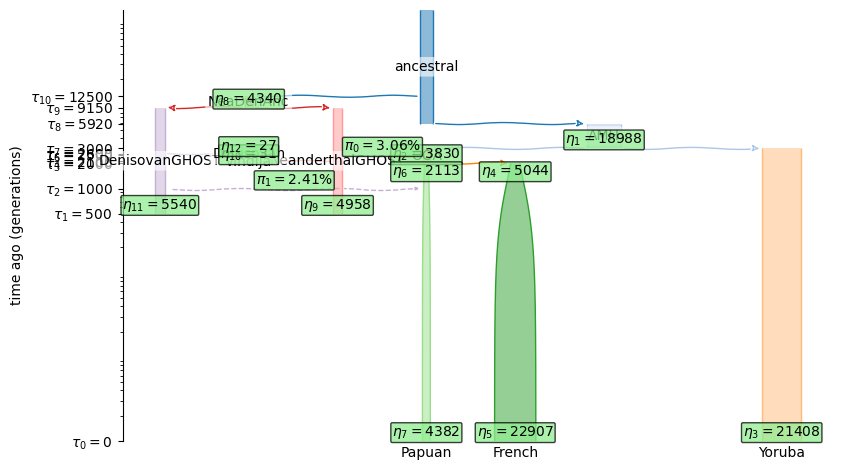

In [91]:
params.tubes(True, True, log_time=True, hide_non_inferreds=True, fontsize=10)

In [29]:
inferred_demo = params.demo_graph

In [35]:
demes.dump(inferred_demo, filename='arc5_pop_size_inferred.yaml', format='yaml', simplified=False)

## Infer admixture params

In [14]:
jsfs = np.load('jsfs_UNIF_Yoruba_French_Papuan_Vindija_Denisovan_11979_108.npy')
jsfs = bootstrap_sample(jsfs, n_SNPs=10000, seed=108)

In [15]:
demo = get_demo('pulse')

In [16]:
sampled_demes = ('Yoruba', 'French', 'Papuan', 'Vindija', 'Denisovan')
sample_sizes = [10, 10, 10, 2, 2] # Sampled 50 from YRI and French

In [17]:
momi = Momi(demo, sampled_demes, sample_sizes, jitted=True)

In [29]:
params = Params(momi)
params.set_train_all_pis(True)

In [53]:
# Initilize OPTAX parameters
optimizer = optax.adam(learning_rate=0.01)
theta_train_dict = params.theta_train_dict(True)
opt_state = optimizer.init(theta_train_dict)

In [54]:
LL = []

In [57]:
# Training
theta_train_dict, opt_state, LL = optax_for_momi(
    optimizer, momi, params, jsfs, niter=500, transformed=True, 
    theta_train_dict=theta_train_dict,
    opt_state=opt_state,
    LL=LL
)

  0%|          | 0/500 [00:00<?, ?it/s]

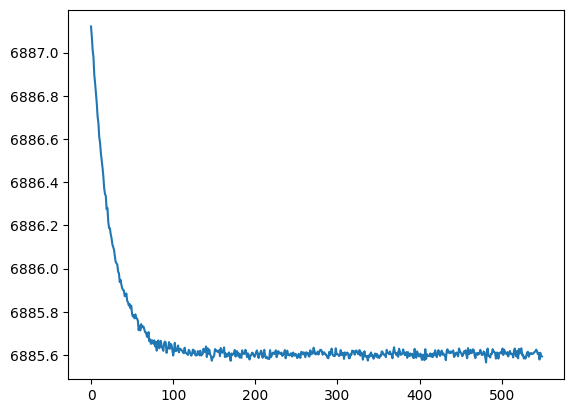

In [58]:
plt.plot(LL)

In [60]:
params.set_optimization_results(theta_train_dict)

In [61]:
params

Parameter,Value,Infer
┦,7.31e+03,❌
𗎆,29.5,❌
𗎇,6.04e+03,❌
𗎈,26.5,❌
┧,1.91e+04,❌
┨,4.32e+03,❌
┩,2.07e+04,❌
┪,4.44e+03,❌
┫,2.27e+04,❌
┬,2.39e+03,❌
